In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
import itertools
from collections import defaultdict, Counter
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import jaccard
import scipy.stats as stats

from bgspy.genome import Genome
from bgspy.utils import load_bed_annotation, read_bed3, ranges_to_masks
from bgspy.utils import read_bigwig, load_cadd_bed_scores, read_phastcons
from bgspy.utils import aggregate_site_array, genome_wide_quantiles
from bgspy.utils import bin_chrom, bin_chroms
from bgspy.genome import process_annotation
from bgspy.data import GenomeData

ImportError: cannot import name 'load_bed_annotation' from 'bgspy.utils' (/home/vsb/projects/bprime/bgspy/utils.py)

In [ ]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200

## Functions

In [ ]:
def annot_summary(annot, seqlens):
    """
    Summarize annotation by chromosome.
    
    Returns (by chromosome) number of features, total bp of 
    features, and fraction of chromosome.    
    """
    annot, all_features = annot
    nfeats = defaultdict(Counter)
    total_bp = defaultdict(Counter)
    frac = defaultdict(Counter)
    lengths = defaultdict(lambda: defaultdict(list))
    for chrom, (ranges, features) in annot.items():
        for (start, end), feature in zip(ranges, features):
            nfeats[chrom][feature] += 1
            total_bp[chrom][feature] += end-start
            lengths[chrom][feature].append(end-start)
    for chrom in total_bp:
        for feature, val in total_bp[chrom].items():
            assert val < seqlens[chrom]
            frac[chrom][feature] = val / seqlens[chrom]
    return nfeats, total_bp, frac, lengths

def annot_merged_summary(annot, genome_length):
    """
    Summarize genome-wide annotation.
    
    Returns number of features, total bp of features, and fraction of genome.
    """
    annot, all_features = annot
    nfeats = Counter()
    total_bp = Counter()
    frac = Counter()
    lengths = defaultdict(list)
    for chrom, (ranges, features) in annot.items():
        for (start, end), feature in zip(ranges, features):
            nfeats[feature] += 1
            total_bp[feature] += end-start
            lengths[feature].append(end-start)

    for feature, val in total_bp.items():
        frac[feature] = val / genome_length
    return nfeats, total_bp, frac, lengths

## Load Genome

In [4]:
hg38_autos = [f"chr{i}" for i in range(1, 23)]

In [5]:
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=hg38_autos)
g.load_recmap("../data/annotation/hapmap_genetic_map.txt")

In [7]:
hg38_len = sum(v for c, v in g.seqlens.items())
hg38_len/1e9

2.875001522

## Comparison of CADD, PhyloP, and Phastcons


### Notes on the tracks and their scores

#### PhastCons

Type: LRT p-value for conserved status (high odds: more likely generated in conserved state of phylo-HMM).

From [BioStars](https://www.biostars.org/p/9490489/): 
> The conserved elements were predicted by running phastCons with the --viterbi option. The predicted elements are segments of the alignment that are likely to have been "generated" by the conserved state of the phylo-HMM. Each element is assigned a log-odds score equal to its log probability under the conserved model minus its log probability under the non-conserved model. The "score" field associated with this track contains transformed log-odds scores, taking values between 0 and 1. (The scores are transformed using a monotonic function of the form a * log(x) + b.) The raw log odds scores are retained in the "name" field and can be seen on the details page or in the browser when the track's display mode is set to "pack" or "full".

#### PhyloP:

Type: score = -log(p) but positive numbers are conserved, negative are fast-evolving. So conserved segments
are those scores > 0, and we only consider those for tail probabilities, etc.

> In the phyloP plots, sites predicted to be conserved are assigned positive scores (and shown in blue), while sites predicted to be fast-evolving are assigned negative scores (and shown in red).


#### CADD

> They summarize the extent to which the variant is likely to have derived from the proxy-neutral (negative values) or proxy-deleterious (positive values) class. Because they have no absolute meaning, they cannot be directly compared across models with distinct annotation combi- nations, training sets or tuning parameter choices. 'PHRED-scaled' scores are normalized to all potential ∼ 9 billion SNVs, and thereby provide an externally compara- ble unit for analysis.

### Fraction of the Genome in Various Annotations

What fraction of the autosomal genome do various strongly conserved annotations occupy? 

In [24]:
beds = {
    # what McVicker et al use:
    'phastcons': '../data/annotation/conserved_phastcons.bed.gz',

    'cds+phastcons':                                  '../data/annotation/conserved_cds_phastcons.bed.gz',
    'cds+utrs':                                       '../data/annotation/conserved_cds_utrs.bed.gz',
    'cds+utrs+phastcons':                             '../data/annotation/conserved_cds_utrs_phastcons.bed.gz',
    'cds+utrs+phastcons+other':                       '../data/annotation/conserved_cds_utrs_phastcons_full.bed.gz',
    'cds+utrs+phastcons+regulatory':                  '../data/annotation/conserved_cds_utrs_regulatory_phastcons.bed.gz',
    'cds+utrs+phastcons+regulatory+other':            '../data/annotation/conserved_cds_utrs_regulatory_phastcons_full.bed.gz',
    'cds+utrs+introns':                               '../data/annotation/conserved_cds_utrs_introns.bed.gz',
    'cds+utrs+introns+phastcons':                     '../data/annotation/conserved_cds_utrs_introns_phastcons.bed.gz',
    'cds+utrs+promoters':                             '../data/annotation/conserved_cds_utrs_promoters2kb.bed.gz'
}

In [25]:
def calc_bed_coverage(f, seqlens):
    bed = read_bed3(f, g.seqlens)
    return sum([e-s for s, e in itertools.chain(*bed.values())]) / sum(seqlens.values())

In [26]:
annot_coverage = {k: np.round(calc_bed_coverage(f, g.seqlens), 4) for k, f in beds.items()}

In [27]:
annot_coverage

{'phastcons': 0.0508,
 'cds+phastcons': 0.0548,
 'cds+utrs': 0.0288,
 'cds+utrs+phastcons': 0.0687,
 'cds+utrs+phastcons+other': 1.0,
 'cds+utrs+phastcons+regulatory': 0.2199,
 'cds+utrs+phastcons+regulatory+other': 1.0,
 'cds+utrs+introns': 0.4229,
 'cds+utrs+introns+phastcons': 0.4454,
 'cds+utrs+promoters': 0.0568}

#### Load CADD, PhyloP, PhastCons, and Genomic Element Tracks

In [ ]:
# created in the annotation Snakefile
cadd = np.load('../data/annotation/cadd_whole_genome_SNVs.npz')

In [ ]:
# bed file annotation to bp (e.g. not CADD and phylop)
annot = {c: ranges_to_masks(read_bed3(f), g.seqlens) for c, f in beds.items()}

In [ ]:
# created in the annotation Snakefile
phylop = np.load('../data/annotation/hg38.phyloP30way.npz')

### Phastcons, PhyloP, and CADD top regions comparison

In [ ]:
alpha = 0.06
cadd_thresh, cadd_phred_samples = genome_wide_quantiles(cadd, 1-alpha, subsample_chrom=0.001, return_samples=True)

In [ ]:
phylop_thresh, _ = genome_wide_quantiles(phylop, 1-alpha, subsample_chrom=0.001, return_samples=True)

In [ ]:
gd = GenomeData(g)
gd.load_accessibile_masks('../data/annotation/no_centro.bed')
gd.load_fasta('../data/annotation/hg38.fa.gz')

In [ ]:
annots = ['phastcons', 'cds+phastcons', 'cds+utrs+phastcons', 'cds+utrs+promoters']

gd.counts = dict()
for chrom in gd.chroms:
    M = [cadd[chrom] > cadd_thresh,
         phylop[chrom] > phylop_thresh]
    for type in annots:
        M.append(annot[type][chrom])
         
    gd.counts[chrom] = np.stack(M).T
gd.labels = ['cadd', 'phylop'] + annots

In [ ]:
cons_bins_100kb = gd.bin_data(1e5, func=lambda x: np.nanmean(x, axis=0))

In [ ]:
cons_bins_1Mb = gd.bin_data(1e6, func=lambda x: np.nanmean(x, axis=0))

In [ ]:
plt.plot(*cons_bins_1Mb.pairs('chr1'), alpha=0.9, linewidth=0.8, label=cons_bins_1Mb.labels)
plt.legend()

In [ ]:
x, y = cons_bins_1Mb.pairs('chr1')
plt.plot(x, (y / np.nanmean(y, axis=0)), alpha=0.9, linewidth=0.8, label=cons_bins_1Mb.labels)
plt.legend()

In [ ]:
plt.plot(*cons_bins_100kb.pairs('chr1'), alpha=0.4, label=cons_bins_100kb.labels)
plt.legend()

### Track Similarities

There are two ways to compare track similarities: 
 1. Per-basepair Jaccard similarity scores.
 2. Pearson correlation in fraction conserved per window (at different scales).

In [ ]:
def track_corr(binned_data):
    all_data = []
    for chrom, data in binned_data.data().items():
        X = data[~np.isnan(data).any(axis=1), :]
        all_data.append(X)
    X = np.concatenate(all_data, axis=0)
    return np.corrcoef(X.T)

track_corr(cons_bins_1Mb), track_corr(cons_bins_100kb)

In [ ]:
gd.counts['chr1'].shape

In [ ]:
def jaccard_matrix(x):
    """
    Jaccard similarity matrix.
    """
    pass

In [161]:
1-jaccard(gd.counts['chr1'][:, 0], gd.counts['chr1'][:, 1])

0.19125289222028552

## Binned Per-Basepair Tracks

We also experimented with disjoint feature tracks that span the entire genome, based on binning per-basepair stores.

In [178]:
bin_quantiles = np.sort(1-np.array([0, 0.02, 0.06, 0.1, 0.2, 1]))
bin_quantiles

array([0.  , 0.8 , 0.9 , 0.94, 0.98, 1.  ])

In [180]:
phylop_cuts, phylop_samples = genome_wide_quantiles(phylop, bin_quantiles, subsample_chrom=0.001, return_samples=True)

In [181]:
phylop_cuts

array([-12.02799988,   0.68900001,   0.97000003,   1.08599997,
         1.20700002,   1.31200004])

## Recombination

To validate the recombination map (and all our interpolators, etc) I downloaded a human hg38 recombination map mentionedin [this thread](https://github.com/statgen/locuszoom-standalone/issues/1), used by LocusZoom. It has cummulative map positions, which is a good way to validate our interpolation.

Note that during validation, I found that quadratic interpolation was leading to some very odd results, so it's best to use linear. 

In [1]:
g.recmap

NameError: name 'g' is not defined

This total map length (including X) is in line with the total map length published by [Broman et al. (1998)](https://pubmed.ncbi.nlm.nih.gov/9718341/).

In [42]:
d = pd.read_csv('../data/annotation/recomb-hg38/genetic_map_GRCh38_merged.tab', sep='\t')

In [43]:
d.head()

,chrom,pos,recomb_rate,pos_cm
0,chr10,48232,0.1614,0.002664
1,chr10,48486,0.1589,0.002705
2,chr10,50009,0.1590,0.002947
3,chr10,52147,0.1574,0.003287
4,chr10,52541,0.1592,0.003349


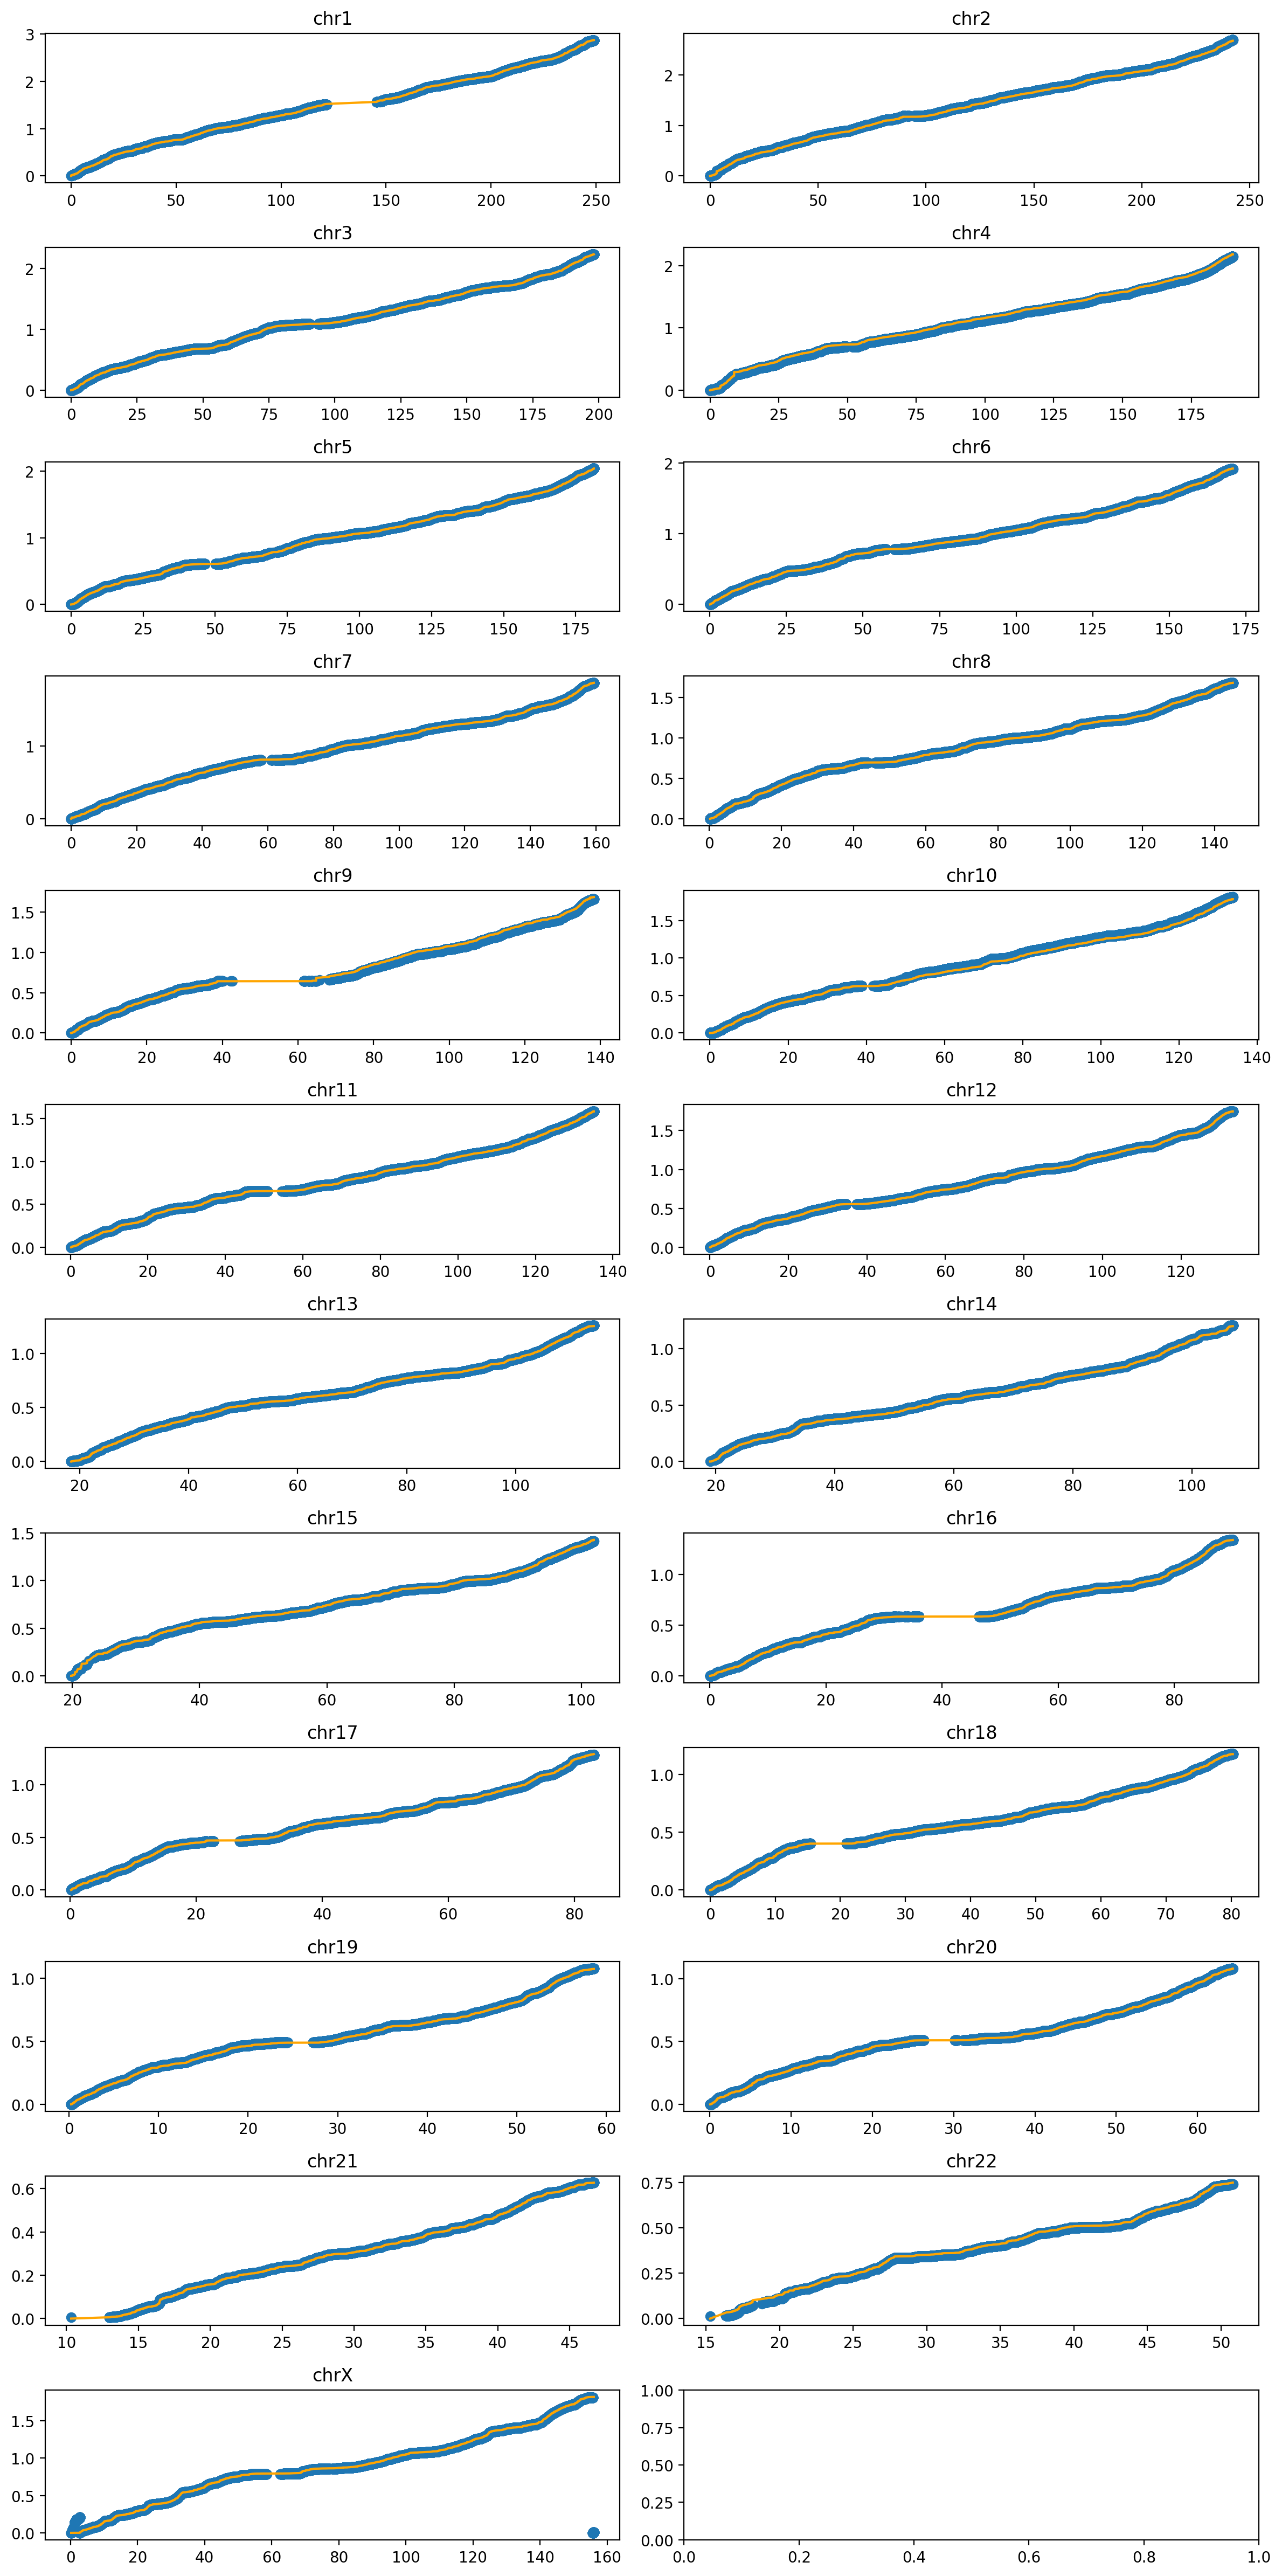

In [45]:

grid = list(itertools.product(range(12), range(2)))

fig, axs = plt.subplots(ncols=2, nrows=12, figsize=(12, 24))

for i, chrom in enumerate(g.chroms):
    ii, jj = grid[i]
    ax = axs[ii, jj] 
    d_chr = d.loc[d.chrom == chrom]
    pos = np.unique(d_chr.pos)
    y = g.recmap.lookup(chrom, pos, cummulative=True)
    ax.plot(pos/1e6, y, label='linear interpolated', c='orange')
    ax.scatter(d_chr['pos']/1e6, d_chr['pos_cm']/100, label='alt map')
    #ax.set_ylabel('cummulative map position (Morgans)')
    #ax.set_xlabel('position')
    ax.set_title(chrom)

plt.tight_layout()

Same as above, but with randomly selected sites to interpolate -- this is a test of the interpolation function. 

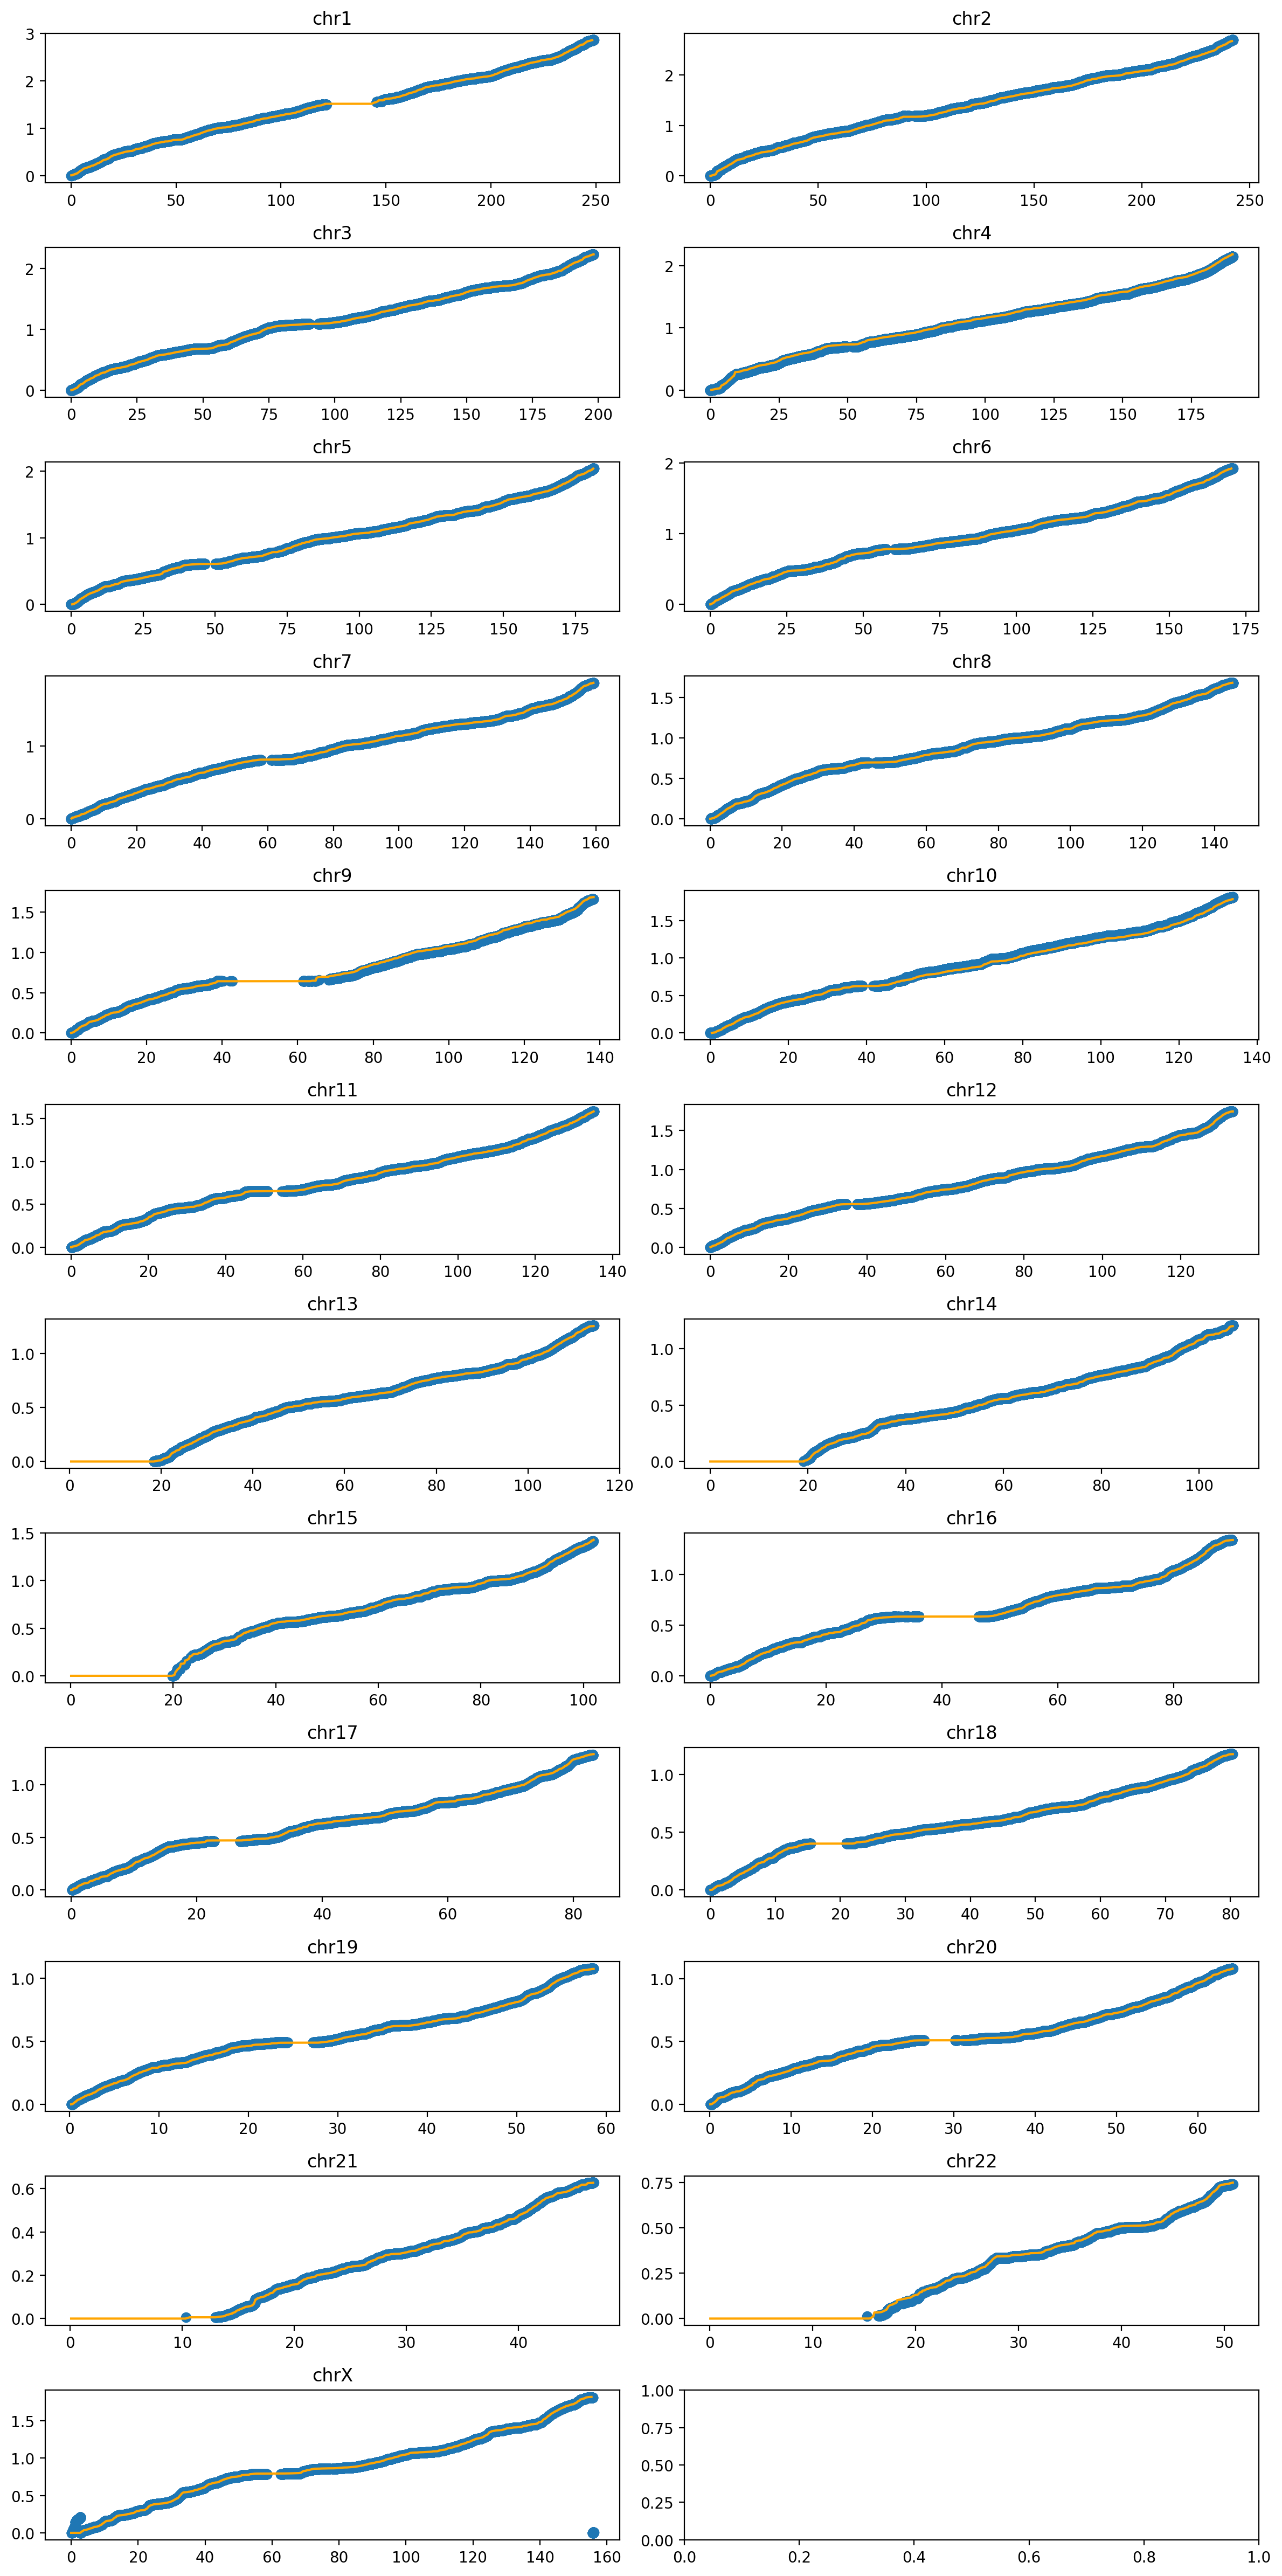

In [12]:

grid = list(itertools.product(range(12), range(2)))

fig, axs = plt.subplots(ncols=2, nrows=12, figsize=(12, 24))

for i, chrom in enumerate(g.chroms):
    ii, jj = grid[i]
    ax = axs[ii, jj] 
    d_chr = d.loc[d.chrom == chrom]
    pos = np.sort(np.random.randint(0, g.seqlens[chrom], 1000))
    y = g.recmap.lookup(chrom, pos, cummulative=True)
    ax.scatter(d_chr['pos']/1e6, d_chr['pos_cm']/100, label='alt map')
    ax.plot(pos/1e6, y, label='linear interpolated', c='orange')    
    #ax.set_ylabel('cummulative map position (Morgans)')
    #ax.set_xlabel('position')
    ax.set_title(chrom)

plt.tight_layout()